In [1]:
import numpy as np
import torch
import socket
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from pathlib import Path
from dataset import create_data_velocity_centeroutreach, \
                    create_data_velocity_random, \
                        perturb
from modeldef import RNN,test
import pandas as pd

In [2]:
directory = Path.cwd() / 'results'
name = 'test' # why is the model trained on test data?
# name = 'train'
savname = directory / name
params = np.load(savname / 'params.npy',allow_pickle=True).item()
protocol = params['model']['protocol']
for phase in range(len(protocol)):
    training_trials = protocol[phase][2]
    print(training_trials)

loss_list = []

1
1
1
0
0


In [94]:
df = pd.DataFrame(params)
df

,model,data,directory,name,p1
n,1000,NaN,/home/jawad/feulner_code/results,test,NaN
tau,0.05,NaN,/home/jawad/feulner_code/results,test,NaN
nonlin,relu,NaN,/home/jawad/feulner_code/results,test,NaN
grec,0,NaN,/home/jawad/feulner_code/results,test,NaN
fb_initial,1,NaN,/home/jawad/feulner_code/results,test,NaN
fb_sparsity,1.0,NaN,/home/jawad/feulner_code/results,test,NaN
fb_type,poserrorfb,NaN,/home/jawad/feulner_code/results,test,NaN
rec_sparsity,1.0,NaN,/home/jawad/feulner_code/results,test,NaN
in_initial,3.5,NaN,/home/jawad/feulner_code/results,test,NaN
input_dim,3,7,/home/jawad/feulner_code/results,test,NaN


In [95]:
# LOAD PARAMETERS ###################
directory = Path.cwd() / 'results'
name = name
savname = directory / name
    
params = np.load(savname / 'params.npy',allow_pickle=True).item()
protocol = params['model']['protocol']

if directory!=params['directory'] or name!=params['name']:
    print('Naming is inconsistent!')

In [96]:
# SETUP SIMULATION #################
rand_seed = params['model']['rand_seed']
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

# GPU usage 
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    torch.set_default_device('cuda')
else:
    dtype = torch.FloatTensor
    torch.set_default_device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

params['model'].update({'dtype':dtype,'device':device})


In [97]:
params.keys()

dict_keys(['model', 'data', 'directory', 'name', 'p1'])

In [98]:
df_1_model = pd.DataFrame(params['model'])
df_2_data = pd.DataFrame(params['data']) # where is the description of the data?

print(df_1_model.columns)
print(df_2_data.columns)
print(params['p1']) # what is the function of this dictionary?

Index(['n', 'tau', 'nonlin', 'grec', 'fb_initial', 'fb_sparsity', 'fb_type',
       'rec_sparsity', 'in_initial', 'input_dim', 'output_dim', 'fwd_delay',
       'fb_delay', 'dt', 'tsteps', 'rand_seed', 'noise_stim_amp', 'noise_amp',
       'noise_kernel_size', 'protocol', 'rot_phi', 'alpha1', 'beta1', 'gamma1',
       'clipgrad', 'lr', 'batch_size', 'dtype', 'device'],
      dtype='object')
Index(['ntrials', 'tsteps', 'dt', 'input_dim', 'output_dim', 'vel', 'p_test',
       'go_to_peak', 'stim_on', 'random', 'center-out-reach'],
      dtype='object')
{'amp': 10, 'pratio': 0.75, 'halflength': 5, 'from': 20, 'upto': 190}


In [99]:
# CREATE DATA ###################
dataA = create_data_velocity_random(params['data'])
dataB = create_data_velocity_centeroutreach(params['data'])
data0 = {'random':dataA,'center-out-reach':dataB}


data0.keys()

RANDOM REACH DATASET CONSTRUCTED!
CENTER OUT REACH DATASET CONSTRUCTED!


dict_keys(['random', 'center-out-reach'])

In [100]:
# SETUP MODEL #################
model = RNN(params['model']['input_dim'],
            params['model']['output_dim'],
            params['model']['n'],
            params['model']['dt']/params['model']['tau'],
            dtype,
            params['model']['dt'],
            params['model']['fwd_delay'],
            params['model']['fb_delay'],
            fb_sparsity=params['model']['fb_sparsity'],
            nonlin=params['model']['nonlin'],
            noiseout=params['model']['noise_amp'],
            noise_kernel_size=params['model']['noise_kernel_size'],
            noisein=params['model']['noise_stim_amp'],
            rec_sparsity=params['model']['rec_sparsity'])

print(model)

# what will the model architecture diagram look like?

RNN(
  (rnn): RNN(3, 1000, num_layers=2, bias=False)
  (output): Linear(in_features=1000, out_features=2, bias=True)
  (feedback): Linear(in_features=2, out_features=1000, bias=True)
  (nonlin): ReLU()
  (mask): Linear(in_features=2, out_features=1000, bias=False)
  (mask2): Linear(in_features=1000, out_features=1000, bias=False)
)


In [101]:
# recurrent initialization
if params['model']['grec']!=0:
    tmp = model.state_dict()
    tmp['rnn.weight_hh_l0'] = torch.FloatTensor(
        params['model']['grec']/np.sqrt(params['model']['n']) \
        * np.random.randn(params['model']['n'],params['model']['n'])).type(dtype)
    model.load_state_dict(tmp,strict=True)

# input initialization
tmp = model.state_dict()
tmp['rnn.weight_ih_l0'] = params['model']['in_initial']*tmp['rnn.weight_ih_l0']
model.load_state_dict(tmp,strict=True)

# SETUP OPTIMIZER #################
criterion = nn.MSELoss(reduction='none') 
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=params['model']['lr']) 



In [102]:
print("Random reach task dataset (training) :")
print(data0['random'].keys())
print(f"Total parameters : {len(data0['random']['params'])}")
print(f"Target array shape : {data0['random']['target'].shape}") #dypte is float64
print(f"Stimulus array shape : {data0['random']['stimulus'].shape}") #dtype is float64
print(f"Peak speed array shape : {data0['random']['peak_speed'].shape}") #dypte is int64


print("\nRandom reach task dataset (test) :")
print(data0['random']['test_set'].keys())
print(f"Target array shape :{data0['random']['test_set']['target'].shape}")
print(f"Stimulus array shape :{data0['random']['test_set']['stimulus'].shape}")
print(f"Peak speed array shape: {data0['random']['test_set']['peak_speed'].shape}")

Random reach task dataset (training) :
dict_keys(['params', 'target', 'peak_speed', 'stimulus', 'test_set'])
Total parameters : 11
Target array shape : (1802, 300, 4)
Stimulus array shape : (1802, 300, 7)
Peak speed array shape : (1802,)

Random reach task dataset (test) :
dict_keys(['target', 'stimulus', 'peak_speed'])
Target array shape :(198, 300, 4)
Stimulus array shape :(198, 300, 7)
Peak speed array shape: (198,)


In [103]:
print("Center out reach task dataset (training) :")
print(data0['center-out-reach'].keys())
print(f"Total parameters : {len(data0['center-out-reach']['params'])}")
print(f"Target array shape : {data0['center-out-reach']['target'].shape}") #float64
print(f"Stimulus array shape : {data0['center-out-reach']['stimulus'].shape}") #float64
print(f"Peak speed array shape : {data0['center-out-reach']['peak_speed'].shape}") #int64
print(f"Tids array shape : {data0['center-out-reach']['tids'].shape}") #int64

print("\nCenter out reach task dataset(test) :")
print(data0['center-out-reach']['test_set'].keys())
print(f"Target arrray shape {data0['center-out-reach']['test_set']['target'].shape}")
print(f"Stimulus arrray shape {data0['center-out-reach']['test_set']['stimulus'].shape}")
print(f"Peak Speed arrray shape {data0['center-out-reach']['test_set']['peak_speed'].shape}")
print(f"Tids arrray shape {data0['center-out-reach']['test_set']['tids'].shape}")

Center out reach task dataset (training) :
dict_keys(['params', 'target', 'peak_speed', 'stimulus', 'test_set', 'tids'])
Total parameters : 11
Target array shape : (1783, 300, 4)
Stimulus array shape : (1783, 300, 7)
Peak speed array shape : (1783,)
Tids array shape : (1783,)

Center out reach task dataset(test) :
dict_keys(['target', 'stimulus', 'peak_speed', 'tids'])
Target arrray shape (217, 300, 4)
Stimulus arrray shape (217, 300, 7)
Peak Speed arrray shape (217,)
Tids arrray shape (217,)


In [104]:
phase = 0
print(len(protocol))
print(protocol[phase][1])
print(protocol[phase])

5
0
['random', 0, 1]


In [105]:
# START INITIAL TRAINING #################
for phase in range(len(protocol)):
    print('\n####### PHASE %d #######'%phase)
    print('Training on %s task'%protocol[phase][0])
    if phase==0: # fix fb weights in first training phase
        tmp = model.state_dict()
        tmp['feedback.weight'] *= params['model']['fb_initial']
        model.load_state_dict(tmp,strict=True)
        model.feedback.weight.requires_grad = False
        np.save(savname / 'data',data0)
    else:
        model.feedback.weight.requires_grad = True
    data = data0[protocol[phase][0]]
    
    perturbation = protocol[phase][1]
    training_trials = protocol[phase][2]
    tout = data['target'][:,:,2:]
    tstim = data['stimulus']

   

    # rotate output matrix if perturbation type is VR (2)
    if perturbation==2:
        rot_phi = params['model']['rot_phi']
        rotmat = np.array([[np.cos(rot_phi),-np.sin(rot_phi)],
                            [np.sin(rot_phi),np.cos(rot_phi)]])
        state_dict = model.state_dict()
        state_dict['output.weight'] = dtype(rotmat) @ \
                                        state_dict['output.weight']
        model.load_state_dict(state_dict, strict=True)

    # convert to pytorch form
    target = torch.zeros(training_trials, params['model']['tsteps'], 
        params['model']['batch_size'], params['model']['output_dim']).type(dtype)
    print (f"Target tensor shape = {target.shape}")
    stimulus = torch.zeros(training_trials, params['model']['tsteps'], 
        params['model']['batch_size'], tstim.shape[-1]).type(dtype)
    print (f"Stimulus tensor shape = {stimulus.shape}")
    pert = torch.zeros(training_trials, params['model']['tsteps'], 
        params['model']['batch_size'], params['model']['output_dim']).type(dtype)
    print (f"Perturbation tensor shape = {pert.shape}")
    
    for j in range(training_trials):
        idx = np.random.choice(range(tout.shape[0]),params['model']['batch_size'],
                                replace=False)
        target[j] = torch.Tensor(tout[idx].transpose(1,0,2)).type(dtype)
        stimulus[j] = torch.Tensor(tstim[idx].transpose(1,0,2)).type(dtype)
        print(f"Target tensor (from data) shape = {target[j].shape}")
        print(f"Stimulus tensor (from data) shape = {stimulus[j].shape}")
        # insert perturbation if perturbation type is random push (1)
        if perturbation==1:
            pert[j] = perturb(pert[j],params['model']['batch_size'],params['p1'])
            print(f"Perturbation tensor (from data) shape = {pert[j].shape}")
    # ACTUAL TRAINING STARTS
    lc = []
    model.train()
    for epoch in range(training_trials): 
        toprint = OrderedDict()
        optimizer.zero_grad()
        output,hidden = model(stimulus[epoch],pert[epoch])
        print(f"Output shape ={output.shape}")
        loss_train = criterion(output, output*0).mean()
        toprint['Loss'] = loss_train
        
        # add regularization
        # term 1: parameters
        regin = params['model']['alpha1']*model.rnn.weight_ih_l0.norm(2)
        regout = params['model']['alpha1']*model.output.weight.norm(2)
        regoutb = params['model']['alpha1']*model.output.bias.norm(2)
        regfb = params['model']['alpha1']*model.feedback.weight.norm(2)
        regfbb = params['model']['alpha1']*model.feedback.bias.norm(2)
        regrec = params['model']['gamma1']*model.rnn.weight_hh_l0.norm(2)
        toprint['In'] = regin
        toprint['Rec'] = regrec
        toprint['Out'] = regout
        toprint['OutB'] = regoutb
        toprint['Fb'] = regfb
        toprint['FbB'] = regfbb
        # term 2: rates
        regact = params['model']['beta1']*hidden.pow(2).mean() 
        toprint['Act'] = regact
        
        loss = loss_train+regin+regrec+regout+regoutb+regact+regfbb+regfb
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 
                                        params['model']['clipgrad'])
        optimizer.step()
            
        train_running_loss = [loss_train.detach().item(),regact.detach().item(),
                                regin.detach().item(), regrec.detach().item(),
                                regout.detach().item(), regoutb.detach().item(),
                                regfb.detach().item(), regfbb.detach().item()]
        print(('Epoch=%d | '%(epoch)) +" | ".join("%s=%.4f"%(k, v) for \
                                                    k, v in toprint.items()))
        lc.append(train_running_loss)       
        loss_list.append(train_running_loss)      

    # save this phase
    torch.save({'epoch': training_trials,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lc':np.array(lc),
                'params':params
                }, savname / ('phase'+str(phase)+'_training'))
    print('MODEL TRAINED!')
    


####### PHASE 0 #######
Training on random task
Target tensor shape = torch.Size([1, 300, 20, 2])
Stimulus tensor shape = torch.Size([1, 300, 20, 7])
Perturbation tensor shape = torch.Size([1, 300, 20, 2])
Target tensor (from data) shape = torch.Size([300, 20, 2])
Stimulus tensor (from data) shape = torch.Size([300, 20, 7])
Output shape =torch.Size([300, 20, 2])
Epoch=0 | Loss=13.8102 | In=0.0035 | Rec=0.0183 | Out=0.0008 | OutB=0.0000 | Fb=0.0184 | FbB=0.0129 | Act=0.0054
MODEL TRAINED!

####### PHASE 1 #######
Training on random task
Target tensor shape = torch.Size([1, 300, 20, 2])
Stimulus tensor shape = torch.Size([1, 300, 20, 7])
Perturbation tensor shape = torch.Size([1, 300, 20, 2])
Target tensor (from data) shape = torch.Size([300, 20, 2])
Stimulus tensor (from data) shape = torch.Size([300, 20, 7])
Output shape =torch.Size([300, 20, 2])
Epoch=0 | Loss=3.2811 | In=0.0035 | Rec=0.0183 | Out=0.0008 | OutB=0.0000 | Fb=0.0184 | FbB=0.0129 | Act=0.0018
MODEL TRAINED!

####### PHAS

/home/jawad/feulner_code/modeldef.py:250: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


MODEL TESTED!


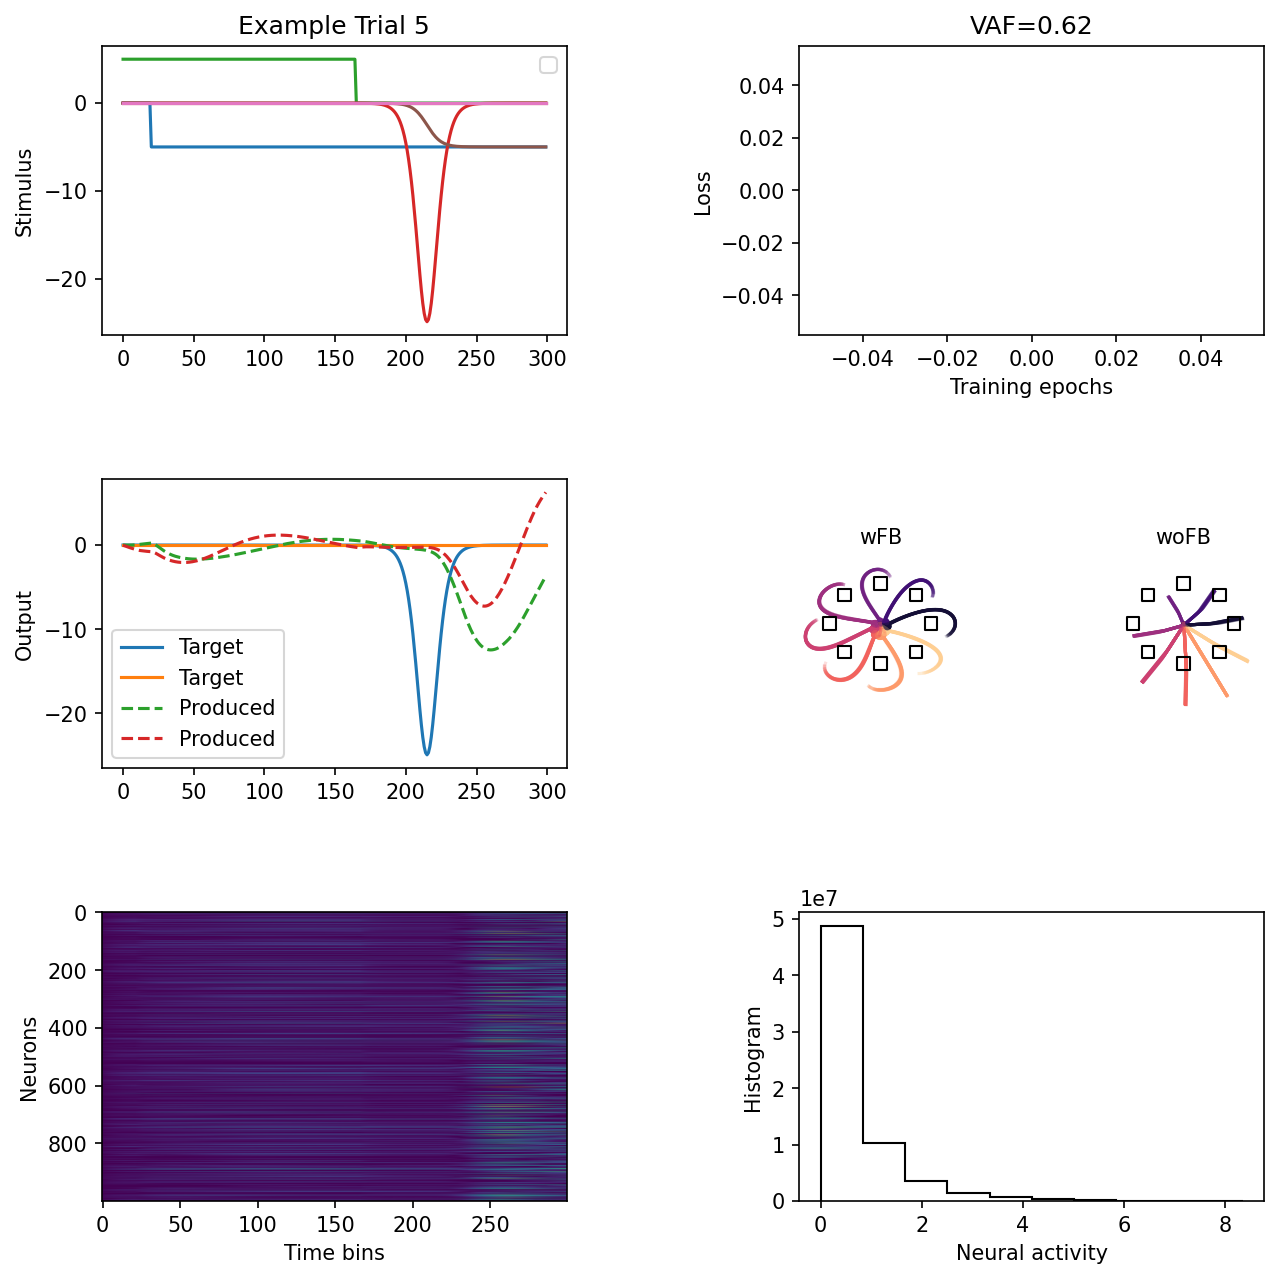

In [106]:
# test model
model.eval()
test(model,data,params,str(savname / ('phase'+str(phase)+'_')),lc,
                dopert=0 if perturbation==2 else perturbation,
                dataC=dataB)
print('MODEL TESTED!')
